# Reinforcement Learning Individual Assignment 

Student name: Victor Girou

## Import and dependencies

In [1]:
!pip install git+https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git

  Cloning https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git to c:\users\victo\appdata\local\temp\pip-req-build-4x64e5s5
  Resolved https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git to commit ca2797e9270195313423324c9d0f205f6cbb3d28
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/953.8 kB ? eta -:--:--
   ---------------------------------------- 10.2/953.8 kB ? eta -:--:--
   ------------------ --------------------- 450.6/953.8 kB 5.6 MB/s eta 0:00:01
   --------------------------------------- 953.8/953.8 kB 10.0 MB/s eta 0:00:00
  Created wheel for text-flappy-bird-gym: filename=text_flappy_bird_gym-0.1.1-py3-none-any.whl size=7841 sha256=44f7d8d9c80c4afbdc13ede2b0fb40a8829b9e3c13ef6f5d28f2abc561055ec6
  Stored in directory: C:\Users\victo\AppData\Local\Temp\pip-ephem-wheel-cache-2lrkncyr\wheels\a1\07

  Running command git clone --filter=blob:none --quiet https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git 'C:\Users\victo\AppData\Local\Temp\pip-req-build-4x64e5s5'


In [1]:
import os, sys
import gymnasium as gym
import time
import numpy as np
from collections import defaultdict

import text_flappy_bird_gym
import matplotlib.pyplot as plt

from utils import *

## 1. Monte Carlo based agent

In [2]:
def mc_control(env, num_episodes, alpha, gamma=1.0, max_steps=500, eps_start=1.0, eps_decay=.99999, eps_min=0.05):
    nA = env.action_space.n

    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(nA))
    epsilon = eps_start
    
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()

        # set the value of epsilon
        epsilon = max(epsilon*eps_decay, eps_min)

        # generate an episode by following epsilon-greedy policy
        episode = generate_episode_from_Q(env, Q, epsilon, nA, max_steps=max_steps)

        # update the action-value function estimate using the episode
        Q = update_Q(env, episode, Q, alpha, gamma)

    # determine the policy corresponding to the final action-value function estimate
    policy = dict((k, np.argmax(v)) for k, v in Q.items())

    return policy, Q

In [29]:
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)

In [51]:
policy_mc, Q_mc = mc_control(env, 200000, 0.2, gamma=1)

Episode 200000/200000.

## Evaluation

In [52]:
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
cum_R = []
scores = []

for e in range(100):
    obs = env.reset()[0]
    t = 0
    R = []
    done = False
    # iterate
    while True:

        # Select next action
        if str(obs) in policy_mc.keys():
            
            action = policy_mc[str(obs)]  # for an agent, action = agent.policy(observation)
        else:
            print('Random action !!!!!!')
            action = env.action_space.sample()
        # Appy action and return new observation of the environment
        obs, reward, done, _, info = env.step(action)
        R.append(reward)

        # If player is dead break
        if done:
            break

        t+=1

        if t > 1000:
            break
    cum_R.append(np.sum(R))
    scores.append(info['score'])

In [53]:
np.mean(scores)

27.75

In [54]:
np.std(scores)

27.869472546139082

In [55]:
np.mean(cum_R)

288.44

In [56]:
np.std(cum_R)

278.4334864918371

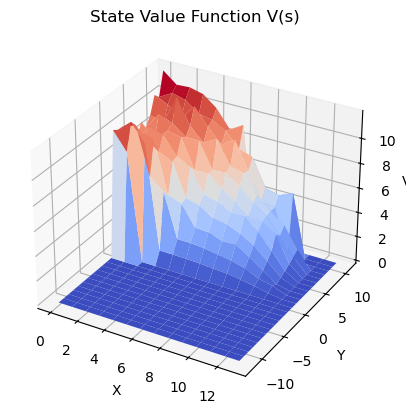

In [9]:
plot_state_value_function(Q, 'mc')

## 2. Sarsa($\lambda$)

Now we will implement the algorithm Sarsa($\lambda$) introduced in Section 12.7 in  Sutton and Barto

In [10]:
def sarsa_lambda(env, num_episodes, alpha, lambda_, max_timestep=100, gamma=1, eps_start=1.0, eps_decay=0.999, eps_min=0.01):

    n_actions = env.action_space.n
    
    # initialize empty dictionary of arrays for Q and Eligibility Trace
    Q = defaultdict(lambda: np.ones(n_actions))
    E = defaultdict(lambda: np.zeros(n_actions))
    epsilon = eps_start

    for episode in range(1, num_episodes+1):

        if episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(episode, num_episodes), end="")
            sys.stdout.flush()

        obs = env.reset()
        obs = obs[0]
        done = False
        t = 0

        # Select first action with epsilon greedy policy

        if str(obs) in list(Q.keys()):
            action = np.random.choice(np.arange(n_actions), p=get_probs(Q[str(obs)], epsilon, n_actions))
        else:
            action = env.action_space.sample()
            Q[str(obs)] = np.zeros(n_actions)

        for t in range(max_timestep):
            
            next_obs, reward, done, _, info = env.step(action)

            if str(next_obs) in list(Q.keys()):
                
                next_action = np.random.choice(np.arange(n_actions), p=get_probs(Q[str(next_obs)], epsilon, n_actions))

            else:
                next_action = env.action_space.sample()
                Q[str(next_obs)] = np.zeros(n_actions)
                
            q_val = Q[str(obs)][action]
            next_q_val = (not done) * Q[str(next_obs)][next_action]
            delta = reward + gamma * next_q_val - q_val
            
            E[str(obs)][action] += 1

            # update Q values and Eligibility
            for o in Q.keys():

                Q[o][:] += alpha * delta * E[o][:]
                E[o][:] = gamma*lambda_*E[o][:]
            
            obs = next_obs
            action = next_action

            if done:
                break

        # set the value of epsilon
        epsilon = max(epsilon*eps_decay, eps_min)


    
    # determine the policy corresponding to the final action-value function estimate
    policy = dict((k, np.argmax(v)) for k, v in Q.items())
    return policy, Q

### Training

In [11]:
policy, Q = sarsa_lambda(env, 4000, alpha=0.2, lambda_=0.9, max_timestep=500, gamma=0.9)

Episode 4000/4000.

### Evaluation

In [24]:
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
cum_R = []
scores = []

for e in range(100):
    obs = env.reset()[0]
    t = 0
    R = []
    done = False
    # iterate
    while True:

        # Select next action
        if str(obs) in policy.keys():
            
            action = policy[str(obs)]  # for an agent, action = agent.policy(observation)
        else:
            print('Random action !!!!!!')
            action = env.action_space.sample()
        # Appy action and return new observation of the environment
        obs, reward, done, _, info = env.step(action)
        R.append(reward)

        # If player is dead break
        if done:
            break

        t+=1

        if t > 1000:
            break
    cum_R.append(np.sum(R))
    scores.append(info['score'])


In [25]:
np.mean(cum_R)

839.6

In [26]:
np.std(cum_R)

271.2745472763709

In [27]:
np.mean(scores)

82.9

In [28]:
np.std(scores)

27.090773337060725

### Plots 

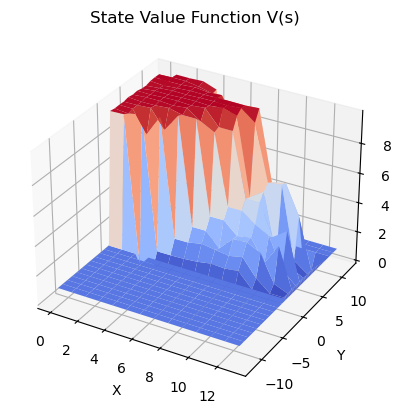

In [16]:
plot_state_value_function(Q, 'sarsa')